# Build a Conditional GAN

### Goals
In this notebook, you're going to make a conditional GAN in order to generate hand-written images of digits, conditioned on the digit to be generated (the class vector). This will let you choose what digit you want to generate.

You'll then do some exploration of the generated images to visualize what the noise and class vectors mean.  

### Learning Objectives
1.   Learn the technical difference between a conditional and unconditional GAN.
2.   Understand the distinction between the class and noise vector in a conditional GAN.



## Getting Started

For this assignment, you will be using the MNIST dataset again, but there's nothing stopping you from applying this generator code to produce images of animals conditioned on the species or pictures of faces conditioned on facial characteristics.

Note that this assignment requires no changes to the architectures of the generator or discriminator, only changes to the data passed to both. The generator will no longer take `z_dim` as an argument, but  `input_dim` instead, since you need to pass in both the noise and class vectors. In addition to good variable naming, this also means that you can use the generator and discriminator code you have previously written with different parameters.

You will begin by importing the necessary libraries and building the generator and discriminator.

#### Packages and Visualization

In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28), nrow=5, show=True):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in an uniform grid.
    '''
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=nrow)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    if show:
        plt.show()

#### Generator and Noise

In [2]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        input_dim: the dimension of the input vector, a scalar
        im_chan: the number of channels in the images, fitted for the dataset used, a scalar
              (MNIST is black-and-white, so 1 channel is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, input_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.input_dim = input_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(input_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of DCGAN;
        a transposed convolution, a batchnorm (except in the final layer), and an activation.
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, input_dim)
        '''
        x = noise.view(len(noise), self.input_dim, 1, 1)
        return self.gen(x)

def get_noise(n_samples, input_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, input_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        input_dim: the dimension of the input vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, input_dim, device=device)

#### Discriminator

In [3]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
      im_chan: the number of channels in the images, fitted for the dataset used, a scalar
            (MNIST is black-and-white, so 1 channel is your default)
      hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_chan=1, hidden_dim=64):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN; 
        a convolution, a batchnorm (except in the final layer), and an activation (except in the final layer).
        Parameters:
            input_channels: how many channels the input feature representation has
            output_channels: how many channels the output feature representation should have
            kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
            stride: the stride of the convolution
            final_layer: a boolean, true if it is the final layer and false otherwise 
                      (affects activation and batchnorm)
        '''
        if not final_layer:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else:
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size, stride),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_chan)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

## Class Input

In conditional GANs, the input vector for the generator will also need to include the class information. The class is represented using a one-hot encoded vector where its length is the number of classes and each index represents a class. The vector is all 0's and a 1 on the chosen class. Given the labels of multiple images (e.g. from a batch) and number of classes, please create one-hot vectors for each label. There is a class within the PyTorch functional library that can help you.

<details>

<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">get_one_hot_labels</font></code></b>
</font>
</summary>

1.   This code can be done in one line.
2.   The documentation for [F.one_hot](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.one_hot) may be helpful.

</details>


In [4]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_one_hot_labels

import torch.nn.functional as F
def get_one_hot_labels(labels, n_classes):
    '''
    Function for creating one-hot vectors for the labels, returns a tensor of shape (?, num_classes).
    Parameters:
        labels: tensor of labels from the dataloader, size (?)
        n_classes: the total number of classes in the dataset, an integer scalar
    '''
    #### START CODE HERE ####
    return F.one_hot(labels, n_classes)
    #### END CODE HERE ####

In [5]:
assert (
    get_one_hot_labels(
        labels=torch.Tensor([[0, 2, 1]]).long(),
        n_classes=3
    ).tolist() == 
    [[
      [1, 0, 0], 
      [0, 0, 1], 
      [0, 1, 0]
    ]]
)
print("Success!")

Success!


Next, you need to be able to concatenate the one-hot class vector to the noise vector before giving it to the generator. You will also need to do this when adding the class channels to the discriminator.

To do this, you will need to write a function that combines two vectors. Remember that you need to ensure that the vectors are the same type: floats. Again, you can look to the PyTorch library for help.
<details>
<summary>
<font size="3" color="green">
<b>Optional hints for <code><font size="4">combine_vectors</font></code></b>
</font>
</summary>

1.   This code can also be written in one line.
2.   The documentation for [torch.cat](https://pytorch.org/docs/master/generated/torch.cat.html) may be helpful.
3.   Specifically, you might want to look at what the `dim` argument of `torch.cat` does.

</details>


In [6]:
# UNQ_C2 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: combine_vectors
def combine_vectors(x, y):
    '''
    Function for combining two vectors with shapes (n_samples, ?) and (n_samples, ?).
    Parameters:
      x: (n_samples, ?) the first vector. 
        In this assignment, this will be the noise vector of shape (n_samples, z_dim), 
        but you shouldn't need to know the second dimension's size.
      y: (n_samples, ?) the second vector.
        Once again, in this assignment this will be the one-hot class vector 
        with the shape (n_samples, n_classes), but you shouldn't assume this in your code.
    '''
    # Note: Make sure this function outputs a float no matter what inputs it receives
    #### START CODE HERE ####
    combined = torch.cat((x.float(), y.float()), dim=1)
    #### END CODE HERE ####
    return combined

In [7]:
combined = combine_vectors(torch.tensor([[1, 2], [3, 4]]), torch.tensor([[5, 6], [7, 8]]));
# Check exact order of elements
assert torch.all(combined == torch.tensor([[1, 2, 5, 6], [3, 4, 7, 8]]))
# Tests that items are of float type
assert (type(combined[0][0].item()) == float)
# Check shapes
combined = combine_vectors(torch.randn(1, 4, 5), torch.randn(1, 8, 5));
assert tuple(combined.shape) == (1, 12, 5)
assert tuple(combine_vectors(torch.randn(1, 10, 12).long(), torch.randn(1, 20, 12).long()).shape) == (1, 30, 12)
print("Success!")

Success!


## Training
Now you can start to put it all together!
First, you will define some new parameters:

*   mnist_shape: the number of pixels in each MNIST image, which has dimensions 28 x 28 and one channel (because it's black-and-white) so 1 x 28 x 28
*   n_classes: the number of classes in MNIST (10, since there are the digits from 0 to 9)

In [8]:
mnist_shape = (1, 28, 28)
n_classes = 10

And you also include the same parameters from previous assignments:

  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type


In [9]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST('.', download=False, transform=transform),
    batch_size=batch_size,
    shuffle=True)

Then, you can initialize your generator, discriminator, and optimizers. To do this, you will need to update the input dimensions for both models. For the generator, you will need to calculate the size of the input vector; recall that for conditional GANs, the generator's input is the noise vector concatenated with the class vector. For the discriminator, you need to add a channel for every class.

In [10]:
# UNQ_C3 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED FUNCTION: get_input_dimensions
def get_input_dimensions(z_dim, mnist_shape, n_classes):
    '''
    Function for getting the size of the conditional input dimensions 
    from z_dim, the image shape, and number of classes.
    Parameters:
        z_dim: the dimension of the noise vector, a scalar
        mnist_shape: the shape of each MNIST image as (C, W, H), which is (1, 28, 28)
        n_classes: the total number of classes in the dataset, an integer scalar
                (10 for MNIST)
    Returns: 
        generator_input_dim: the input dimensionality of the conditional generator, 
                          which takes the noise and class vectors
        discriminator_im_chan: the number of input channels to the discriminator
                            (e.g. C x 28 x 28 for MNIST)
    '''
    #### START CODE HERE ####
    C, W, H = mnist_shape[0], mnist_shape[1], mnist_shape[2] 
    generator_input_dim = z_dim + n_classes; 
    discriminator_im_chan = C + n_classes;
    #### END CODE HERE ####
    return generator_input_dim, discriminator_im_chan

In [11]:
def test_input_dims():
    gen_dim, disc_dim = get_input_dimensions(23, (12, 23, 52), 9)
    assert gen_dim == 32
    assert disc_dim == 21
test_input_dims()
print("Success!")

Success!


In [12]:
generator_input_dim, discriminator_im_chan = get_input_dimensions(z_dim, mnist_shape, n_classes)

gen = Generator(input_dim=generator_input_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator(im_chan=discriminator_im_chan).to(device)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

Now to train, you would like both your generator and your discriminator to know what class of image should be generated. There are a few locations where you will need to implement code.

For example, if you're generating a picture of the number "1", you would need to:
  
1.   Tell that to the generator, so that it knows it should be generating a "1"
2.   Tell that to the discriminator, so that it knows it should be looking at a "1". If the discriminator is told it should be looking at a 1 but sees something that's clearly an 8, it can guess that it's probably fake

There are no explicit unit tests here -- if this block of code runs and you don't change any of the other variables, then you've done it correctly!

Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!



Step 500: Generator loss: 2.2318398966789244, discriminator loss: 0.26302138560637833


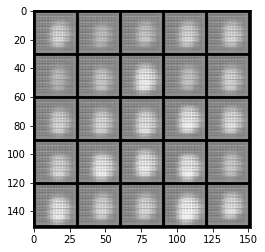

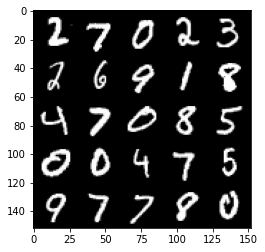

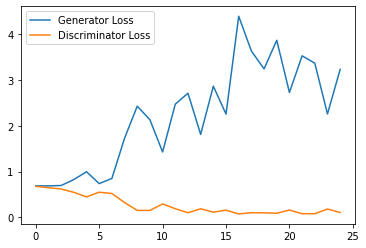

Step 1000: Generator loss: 4.7874256010055545, discriminator loss: 0.031862855601124465


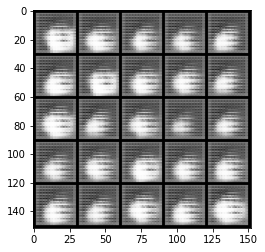

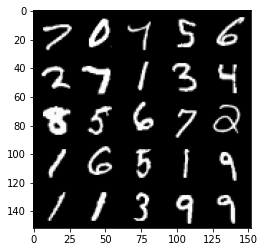

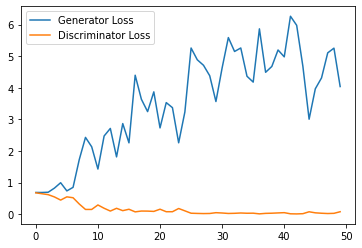

KeyboardInterrupt: 

In [13]:
# UNQ_C4 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
# GRADED CELL
cur_step = 0
generator_losses = []
discriminator_losses = []

#UNIT TEST NOTE: Initializations needed for grading
noise_and_labels = False
fake = False

fake_image_and_labels = False
real_image_and_labels = False
disc_fake_pred = False
disc_real_pred = False

for epoch in range(n_epochs):
    # Dataloader returns the batches and the labels
    for real, labels in tqdm(dataloader):
        cur_batch_size = len(real)
        # Flatten the batch of real images from the dataset
        real = real.to(device)

        one_hot_labels = get_one_hot_labels(labels.to(device), n_classes)
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = image_one_hot_labels.repeat(1, 1, mnist_shape[1], mnist_shape[2])

        ### Update discriminator ###
        # Zero out the discriminator gradients
        disc_opt.zero_grad()
        # Get noise corresponding to the current batch_size 
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        
        # Now you can get the images from the generator
        # Steps: 1) Combine the noise vectors and the one-hot labels for the generator
        #        2) Generate the conditioned fake images
       
        #### START CODE HERE ####
        noise_and_labels = combine_vectors(fake_noise, one_hot_labels)
        fake = gen(noise_and_labels)#gen.forward(noise_and_labels) no usar
        #### END CODE HERE ####
        
        # Make sure that enough images were generated
        assert len(fake) == len(real)
        # Check that correct tensors were combined
        assert tuple(noise_and_labels.shape) == (cur_batch_size, fake_noise.shape[1] + one_hot_labels.shape[1])
        # It comes from the correct generator
        assert tuple(fake.shape) == (len(real), 1, 28, 28)

        # Now you can get the predictions from the discriminator
        # Steps: 1) Create the input for the discriminator
        #           a) Combine the fake images with image_one_hot_labels, 
        #              remember to detach the generator (.detach()) so you do not backpropagate through it
        #           b) Combine the real images with image_one_hot_labels
        #        2) Get the discriminator's prediction on the fakes as disc_fake_pred
        #        3) Get the discriminator's prediction on the reals as disc_real_pred
        
        #### START CODE HERE ####
        fake_image_and_labels = combine_vectors(fake.detach(), image_one_hot_labels)
        real_image_and_labels = combine_vectors(real, image_one_hot_labels)
        disc_fake_pred = disc(fake_image_and_labels)
        disc_real_pred = disc(real_image_and_labels)
        #### END CODE HERE ####
        
        # Make sure shapes are correct 
        assert tuple(fake_image_and_labels.shape) == (len(real), fake.detach().shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        assert tuple(real_image_and_labels.shape) == (len(real), real.shape[1] + image_one_hot_labels.shape[1], 28 ,28)
        # Make sure that enough predictions were made
        assert len(disc_real_pred) == len(real)
        # Make sure that the inputs are different
        assert torch.any(fake_image_and_labels != real_image_and_labels)
        # Shapes must match
        assert tuple(fake_image_and_labels.shape) == tuple(real_image_and_labels.shape)
        assert tuple(disc_fake_pred.shape) == tuple(disc_real_pred.shape)
        
        
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2
        disc_loss.backward(retain_graph=True)
        disc_opt.step() 

        # Keep track of the average discriminator loss
        discriminator_losses += [disc_loss.item()]

        ### Update generator ###
        # Zero out the generator gradients
        gen_opt.zero_grad()

        fake_image_and_labels = combine_vectors(fake, image_one_hot_labels)
        # This will error if you didn't concatenate your labels to your image correctly
        disc_fake_pred = disc(fake_image_and_labels)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the generator losses
        generator_losses += [gen_loss.item()]
        #

        if cur_step % display_step == 0 and cur_step > 0:
            gen_mean = sum(generator_losses[-display_step:]) / display_step
            disc_mean = sum(discriminator_losses[-display_step:]) / display_step
            print(f"Step {cur_step}: Generator loss: {gen_mean}, discriminator loss: {disc_mean}")
            show_tensor_images(fake)
            show_tensor_images(real)
            step_bins = 20
            x_axis = sorted([i * step_bins for i in range(len(generator_losses) // step_bins)] * step_bins)
            num_examples = (len(generator_losses) // step_bins) * step_bins
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(generator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Generator Loss"
            )
            plt.plot(
                range(num_examples // step_bins), 
                torch.Tensor(discriminator_losses[:num_examples]).view(-1, step_bins).mean(1),
                label="Discriminator Loss"
            )
            plt.legend()
            plt.show()
        elif cur_step == 0:
            print("Congratulations! If you've gotten here, it's working. Please let this train until you're happy with how the generated numbers look, and then go on to the exploration!")
        cur_step += 1

## Exploration
You can do a bit of exploration now!

In [ ]:
# Before you explore, you should put the generator
# in eval mode, both in general and so that batch norm
# doesn't cause you issues and is using its eval statistics
gen = gen.eval()

#### Changing the Class Vector
You can generate some numbers with your new model! You can add interpolation as well to make it more interesting.

So starting from a image, you will produce intermediate images that look more and more like the ending image until you get to the final image. Your're basically morphing one image into another. You can choose what these two images will be using your conditional GAN.

In [ ]:
import math

### Change me! ###
n_interpolation = 15 # Choose the interpolation: how many intermediate images you want + 2 (for the start and end image)
interpolation_noise = get_noise(1, z_dim, device=device).repeat(n_interpolation, 1)

def interpolate_class(first_number, second_number):
    first_label = get_one_hot_labels(torch.Tensor([first_number]).long(), n_classes)
    second_label = get_one_hot_labels(torch.Tensor([second_number]).long(), n_classes)

    # Calculate the interpolation vector between the two labels
    percent_second_label = torch.linspace(0, 1, n_interpolation)[:, None]
    interpolation_labels = first_label * (1 - percent_second_label) + second_label * percent_second_label
    print(interpolation_labels)
    # Combine the noise and the labels
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_labels.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

### Change me! ###
start_plot_number = 1 # Choose the start digit
### Change me! ###
end_plot_number = 7 # Choose the end digit

plt.figure(figsize=(8, 8))
interpolate_class(start_plot_number, end_plot_number)
_ = plt.axis('off')

### Uncomment the following lines of code if you would like to visualize a set of pairwise class 
### interpolations for a collection of different numbers, all in a single grid of interpolations.
### You'll also see another visualization like this in the next code block!
#plot_numbers = [2, 3, 4, 5, 7]
#n_numbers = len(plot_numbers)
#plt.figure(figsize=(8, 8))
#for i, first_plot_number in enumerate(plot_numbers):
#    for j, second_plot_number in enumerate(plot_numbers):
#        plt.subplot(n_numbers, n_numbers, i * n_numbers + j + 1)
#        interpolate_class(first_plot_number, second_plot_number)
#        plt.axis('off')
#plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
#plt.show()
#plt.close()

#### Changing the Noise Vector
Now, what happens if you hold the class constant, but instead you change the noise vector? You can also interpolate the noise vector and generate an image at each step.

In [ ]:
n_interpolation = 9 # How many intermediate images you want + 2 (for the start and end image)

# This time you're interpolating between the noise instead of the labels
interpolation_label = get_one_hot_labels(torch.Tensor([5]).long(), n_classes).repeat(n_interpolation, 1).float()

def interpolate_noise(first_noise, second_noise):
    # This time you're interpolating between the noise instead of the labels
    percent_first_noise = torch.linspace(0, 1, n_interpolation)[:, None].to(device)
    interpolation_noise = first_noise * percent_first_noise + second_noise * (1 - percent_first_noise)
    print(interpolation_noise)
    # Combine the noise and the labels again
    noise_and_labels = combine_vectors(interpolation_noise, interpolation_label.to(device))
    fake = gen(noise_and_labels)
    show_tensor_images(fake, num_images=n_interpolation, nrow=int(math.sqrt(n_interpolation)), show=False)

# Generate noise vectors to interpolate between
### Change me! ###
n_noise = 2 # Choose the number of noise examples in the grid
plot_noises = [get_noise(1, z_dim, device=device) for i in range(n_noise)]
print(plot_noises)
plt.figure(figsize=(8, 8))
for i, first_plot_noise in enumerate(plot_noises):
    for j, second_plot_noise in enumerate(plot_noises):
        plt.subplot(n_noise, n_noise, i * n_noise + j + 1)
        interpolate_noise(first_plot_noise, second_plot_noise)
        plt.axis('off')
plt.subplots_adjust(top=1, bottom=0, left=0, right=1, hspace=0.1, wspace=0)
plt.show()
plt.close()